In [0]:
%reset

CONCLUSION of exp_1 :

1. Using med2 signal gives best classification results

2. Need to use more number of records to capture relation b/w normals and different types of abnormals ( SVEB and VEB ) in different patient

3. Find ways to handle noisy data

4. Ratio of Normal and Abnormal beats taken should be equal and equally distributed among all records - need to select specific records for training.


# [~ Imports ]

In [1]:
import datetime
import os
import random
import statistics as stats
import numpy as np
import scipy.signal as scsig
from scipy.io import loadmat
from scipy.signal import medfilt
import pywt
from pywt import wavedec
#from ecgdetectors import Detectors
#import hrv
import matplotlib
import matplotlib.pyplot as plt
#from PIL import Image
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from keras.utils import to_categorical
import keras.backend as kbend


Using TensorFlow backend.


#[~ Global Section ]

## [~ Data Directories ]

Following directory structure must exist

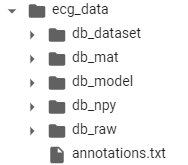

In [2]:
#===========================================================================================================
# DEFINE SOURCE DIRECTORIES
#===========================================================================================================
# > _ base working directory
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data'
print('GLOBAL DIR :: '+global_dir)

# >> 0 global annotation and mapping, common for all ECG from https://physionet.org/about/database/
        # view this file on drive :: https://drive.google.com/open?id=1edhzatX7D3Uo03-d08Lksp807ULlcpgo
global_annot = os.path.join(global_dir, 'annotations.txt' ) 
print('GLOBAL ANNOTATIONS :: '+global_annot)

# >> 1 global mat data directory, source of ecg signal data in .mat format, use loadmat()
global_matdir = os.path.join(global_dir, 'db_mat')
print('GLOBAL MAT DIR :: '+global_matdir)

# >> 2 global npy directory, extract from mat to npy fromat and store here
global_npydir = os.path.join(global_dir, 'db_npy')
os.makedirs(global_npydir , exist_ok = True) 
print('GLOBAL NPY DIR :: '+global_npydir)

# >> 3 global model directory, contains model weights, use load_weights(), save_weights() 
global_modeldir = os.path.join(global_dir, 'db_model') 
os.makedirs(global_modeldir , exist_ok = True) 
print('GLOBAL MODEL DIR :: '+global_modeldir)

# >> 4 global dataset directory, contains manually generated datasets to be used for experiments
global_datadir = os.path.join(global_dir, 'db_dataset') 
os.makedirs(global_datadir , exist_ok = True) 
print('GLOBAL DATA DIR :: '+global_datadir)
#===========================================================================================================

GLOBAL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL ANNOTATIONS :: /content/drive/My Drive/Masters/workdir/ecg_data/annotations.txt
GLOBAL MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_model
GLOBAL DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset


## [~ Annotation Mapping]

In [3]:
#  Define annotation mapping dictionary (from global_annot)
#=========================================================================================================== 
g_map_data = np.loadtxt(global_annot, dtype='str',delimiter="\t")
g_map={}
print('ANNOTATION MAPPING :: ')
for a in g_map_data:
    g_map[a[0]]= int(a[1])
    print(str(a[0])+'\t'+str(a[1])+'\t'+str(a[2]))
    #a[0] = orignal mit label (char)
    #a[1] = mapped integer label (int)
    #a[2] = description (str)
g_map_keys = g_map.keys()
print('\nAnnotations : [' + str(len(g_map_keys))+'] :: ' + str(g_map_keys))
def mapstd(peak_label):
    res = np.zeros(len(peak_label),dtype='int')
    for i in range(0, len(peak_label)):
        res[i] = g_map[peak_label[i]]
    return res

g_LMAX = np.max(np.array(list(g_map.values()))) # this is max mapping value starting from 0
g_LMIN = -1 # this means unmapped (RR beat), 
#anything less than g_LMIN is unmapped(Non RR beat) and anythone greater is mapped(RR beat)
print('Integer Label Range [ '+str(g_LMIN)+ ' : '+str(g_LMAX)+' ]')
g_LABELS= ['N','A']             # labels to use when priniting confusion matrix

ANNOTATION MAPPING :: 
N	0	Normal beat
L	0	Left bundle branch block beat
R	0	Right bundle branch block beat
B	-1	Bundle branch block beat (unspecified)
A	1	Atrial premature beat
a	1	Aberrated atrial premature beat
J	1	Nodal (junctional) premature beat
S	1	Supraventricular premature or ectopic beat (atrial or nodal)
V	1	Premature ventricular contraction
r	1	R-on-T premature ventricular contraction
F	1	Fusion of ventricular and normal beat
e	1	Atrial escape beat
j	1	Nodal (junctional) escape beat
n	1	Supraventricular escape beat (atrial or nodal)
E	1	Ventricular escape beat
/	-1	Paced beat
f	-1	Fusion of paced and normal beat
Q	1	Unclassifiable 
?	-1	Beat not classified during learning
[	-2	Start of ventricular flutter/fibrillation
!	-2	Ventricular flutter wave
]	-2	End of ventricular flutter/fibrillation
x	-2	Non-conducted P-wave (blocked APC)
(	-2	Waveform onset
)	-2	Waveform end
p	-2	Peak of P-wave
t	-2	Peak of T-wave
u	-2	Peak of U-wave
`	-2	PQ junction
'	-2	J-point
^	-2	(Non-capture

##[~ Params ]

In [4]:
#------------------------------------------------
# Hear-Rate Params
#------------------------------------------------
H_min = 20          #bpm
max_rri = 60/H_min  #sec

H_low = 60          #bpm
hig_rri = 60/H_low  #sec

H_hig = 100         #bpm
low_rri = 60/H_hig  #sec

H_max = 240         #bpm
min_rri = 60/H_max  #sec

#------------------------------------------------
# Beat Formation PARAMS - use fixed dimesion of 1 beat morphological
#------------------------------------------------

# first downsample to a basic sampling rate then resample to fixed window which is mid way b/w max_rri to min_rri
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz): '+str(BASIC_SRATE))
v_dim = int(BASIC_SRATE*(max_rri))  # INPUT VECTOR DIMENSION (BEAT VECTOR)
print('Re-sampled Vector Dim(#): '+str(v_dim))

# for figure plots
plotdim_bfigsize = (v_dim/50 , 6)
plotdim_bylim = (-2.5, 3.5)

#------------------------------------------------
# Data files postfix
#------------------------------------------------
# annotations
g_NBEAT_POSTFIX = 'nbeat'
g_BEAT_POSTFIX = 'beat'

# raw signal
g_RAW2_POSTFIX = 'raw2'
g_RAW5_POSTFIX = 'raw5'

# median filtered (baseline fitted) signal
g_MED2_POSTFIX = 'med2'
g_MED5_POSTFIX = 'med5'

# denoised signal (wavelet transform)
g_DEN2_POSTFIX = 'den2'
g_DEN5_POSTFIX = 'den5'

# filtered signal (denoised and baseline fitted)
g_FLT2_POSTFIX = 'flt2'
g_FLT5_POSTFIX = 'flt5'
#------------------------- signal data types--------------------

# file names for representative mean and meadians <-----
g_MEDIAN_POSTFIXL = [ 'medi_med2', 'medi_med5']
g_MEAN_POSTFIXL = [ 'mean_med2',  'mean_med5']
dtype_load_postfixL = [ 'sig_med2', 'sig_med5']

#---------------------------------------------------------------------------------------------------------------------------------------------
# Pre processing Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  

def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

def filter_signal(X,mfltrs_array):
    X0 = X  #read orignal signal
    for mi in range(0,len(mfltrs_array)):
        X0 = medfilt(X0,mfltrs_array[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

def get_minfo(minfo_path):
    f = open(minfo_path,'r')
    ls = f.readlines()
    f.close()
    #la = ls[minfo_line_index].split()    #I67m.mat 16+192 623/mV 16 0 4441 1894 0 II
    return ls # gain at 2 baseline at 4




Basic sampling rate(Hz): 128
Re-sampled Vector Dim(#): 384


## [~ ECG_BINFO CLASS ]

In [0]:
class ecg_binfo:
    def __init__(self, rec):
        self.israte = rec.db.srate
        self.rec = rec # the record object
        self.sr_ratio = BASIC_SRATE/self.israte
        rr_peaks_ants = rec.read_data(g_BEAT_POSTFIX)       # orignal ant file [ *  '625310' 'N' * ]
        # slice array
        rr_peaks_int = rr_peaks_ants[:,0].astype('int')     # col0 : samples * 62531 *  <---------------- not excluded
        rr_ants_str = rr_peaks_ants[:,1]                    # col1 : labels * 'N' *     <---------------- not excluded
        # excluded first and last

        # start of madarchodh section
        #print(rr_peaks_int.shape)
        self.rr_peaks = rr_peaks_int[1:-1]                       # col0 : samples (int) 62531 ==>==>==> sample# (orignal)
        self.rr_prev = rr_peaks_int[0:-2]                       # prev R peak (in samples)
        self.rr_next = rr_peaks_int[2:]                                           # next R peak (in samples)
        self.nos_rr_peaks = len(self.rr_peaks)              # no fo RR peaks (excluding first and last)
        #print(self.rr_peaks.shape)
        #print(self.rr_prev.shape)
        #print(self.rr_next.shape)
        # end of madarchodh section

        self.rr_labels = rr_ants_str[1:-1]                       # col1 : labels (str)  'N'  ==>==>==> mit label (orignal)
        self.rr_peaks_sec = self.rr_peaks / self.israte                # col0 : time in sec (float) ==>==>==> sample (time in sec) sample#/srate
        self.rr_int_labels = mapstd(self.rr_labels)                   # col1 : mapped int labels ==>==>==> int label (mapped -1, 0 ...) cant be -2 in 

        #temporal info
        self.rri_prev = (self.rr_peaks - self.rr_prev) / self.israte    # prev RRI (in sec) 
        self.rri_next = (self.rr_next - self.rr_peaks) / self.israte    # next RRI (in sec) 
        self.rri_delta = (self.rri_next - self.rri_prev)        # difference b/w prev and next RRI in seconds 
        self.rri_dur = (self.rri_next + self.rri_prev) / (2)    # avg of prev and next RRI in seconds ==>==>==> length of the beat (prev R to next R peak)
        self.rr_signal = None

    def load_signal_data(self, data_type, vdim, save_copy, save_postfix):
        sel_sig = self.rec.read_data(data_type) 
        self.rr_signal = np.zeros((0,vdim),dtype = 'float')
        for i in range(0,self.nos_rr_peaks):
            ff, tt = self.rr_prev[i], self.rr_next[i]
            #print(str(ff) + ':' + str(tt))
            
            b_sig = sel_sig[ff:tt]                          # orignal clipped signal
            b_bsig = scsig.resample(b_sig, round(len(b_sig)*self.sr_ratio))      # resampled to BASIC_SRATE Hz
            b_rsig = scsig.resample(b_bsig, v_dim)                    # resampled to vector dimenstion 'v_dim' (Transformed) 
            b_rsig = b_rsig/self.rec.gain                                           # remove manual gain
            self.rr_signal = np.vstack((self.rr_signal,b_rsig))

        if save_copy:
            self.rec.save_data( save_postfix ,self.rr_signal )

        return self.rr_signal

    def read_signal_data(self, load_postfix):
        self.rr_signal = self.rec.read_data(load_postfix)
        #np.save(os.path.join(self.rec.db.dir_npy, self.rec.rec+'_sig.npy'))
        return self.rr_signal


    def get_query_mask(self, query, mask_zero, mask_one):
        emask = np.add(np.zeros(self.nos_rr_peaks), [mask_zero])
        emask[query] = mask_one


## [~ ECG_RECORD CLASS ]

In [0]:

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name

        if recname in db.recs_exc:
            print('WARNING:: Record "'+ recname +'" was excluded from database '+ db.name )
        else:
            if not(recname in db.recs):
                print('WARNING:: Record "'+ recname +'" not found in database '+ db.name )

        self.data = {}                              # dict              dict of npy data file content used in self.read_data('key')
        self.binfo = None                           # class binfo       
        # find the gain
        self.info = get_minfo(os.path.join(db.dir_mat,recname+'m.hea'))#,db.lead2_index+1)  # head has this info at lead2's index
        self.gain = int(self.info[db.lead2_index+1].split()[2].split('/')[0])
        self.gain5 = int(self.info[db.lead5_index+1].split()[2].split('/')[0])
        #print(self.info)

    def read_binfo(self):
        if self.binfo == None:
            self.binfo = ecg_binfo(self)
        return self.binfo
    
    def print_info(self):
        res = ''
        for i in range(0,len(self.info)):
            res+= self.info[i]
        return res

    def read_data(self, data_type):
        if data_type in self.data.keys():
            return self.data[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

    def save_data(self, data_type, data_array):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath
    def del_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        if os.path.exists(ipath):
            os.remove(ipath)
        return ipath
    
    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
        except:
            print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            raise Exception("File not found")
        finally:
            return self.data[data_type] #= np.load(self.dirs[s])
#---------------------------------------------------------------------------------------------------------------------------------------------


##[~ ECG_DB CLASS ]

In [0]:

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  sampling_rate, lead2_index, lead5_index, exclude_rec):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.srate = sampling_rate #int
        self.lead2_index = lead2_index #int
        self.lead5_index = lead5_index #int
        #self.dir_raw = global_dir + dbname+'_raw/' #str
        self.dir_mat = os.path.join(global_matdir , dbname+'_mat') #str
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs_all = set(np.loadtxt(os.path.join(self.dir_mat,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_exc = set(exclude_rec)
        self.recs = set.difference(self.recs_all, self.recs_exc) 
        self.recs_dict = {} # initially empty, will be loaded on demand using function 'get_record'
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'MAT DIR :: ' + self.dir_mat )
        print( 'NPY DIR :: ' + self.dir_npy )
        print( 'S_RATE :: ' + str(self.srate))
        print( 'LEAD2 INDEX  :: ' + str(self.lead2_index))
        print( 'LEAD5 INDEX  :: ' + str(self.lead5_index))
        print( 'RECORD SET :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        return 0

    def get_record(self,rec):
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]
    
    def get_random_record(self):
        rec = random.choice(list(self.recs))
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]

#---------------------------------------------------------------------------------------------------------------------------------------------



## [~ PERFORMANCE]

In [0]:

#=========================================================================================================================
#======================= NEURAL NETWORK PERFORMANCE MEASURES
#=========================================================================================================================
# 3.3 :: define performance evaluation functions

def get_performance(conf_matrix):
    #how many classes? = len of conf_matril
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    res = np.zeros((0,8),dtype ='float64')
    for i in range(0,nos_class):
        # for each class calculate 4 performance measure - ACC, PRE, SEN, SPF, 
        # first compute TP, TN, FP, FN
        TP = conf_matrix[i,i]
        FP = np.sum(conf_matrix[:,i]) - TP
        FN = np.sum(conf_matrix[i,:]) - TP
        TN = np.sum(conf_matrix) - FN - FP - TP

        ACC = (TP+TN)   /   (TP+FP+FN+TN)
        PRE = (TP)      /   (TP+FP)
        SEN = (TP)      /   (TP+FN)
        SPF = (TN)      /   (TN+FP)

        res_i = np.array([TP, FN, FP, TN, ACC, PRE, SEN, SPF])
        res = np.vstack((res,res_i))
    return res


#------------------------------------------------------------------PRINTING

def print_lstr(class_labels):
    g_LSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_LSTR+='\t'+str(class_labels[i])
    return  g_LSTR

def print_cf_row(cf_row,nos_labels):
    res = ''
    for j in range(0,nos_labels):
        res += '\t'+ str(cf_row[j])
    return res
def print_conf_matrix(conf_matrix, suffix, class_labels):
    res=(suffix+'A\\P' + print_lstr(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        res+=(suffix+str(class_labels[i]) + print_cf_row(conf_matrix[i],nos_l )+'\n')
    return res
def print_performance(perf_measures, class_labels):
    nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print ('Class\tACC\tPRE\tSEN\tSPF')
    for i in range(0, nos_class):
        perf_i = np.round(perf_measures [i,:],2)
        #print('\tT.P : '+str(perf_i[0])+'\tF.N : '+str(perf_i[1]))
        #print('\tF.P : '+str(perf_i[2])+'\tT.N : '+str(perf_i[3]))
        print(str(class_labels[i])+'\t'+str(perf_i[4])+'\t'+str(perf_i[5])+'\t'+str(perf_i[6])+'\t'+str(perf_i[7]))
    return
#------------------------------------------------------------------PRINTING

def view_beat(fig_n, rec, peak, signal_data_type):
    
    ant = rec.read_data(g_BEAT_POSTFIX)
    iant = ant[:,0].astype(int)
    ilab = ant[:,1]
    rlab = ilab[iant==peak][0]
    rant = np.where(iant==peak)[0][0]
    ffi = iant[rant-1]
    tti = iant[rant+1]


    isig = (rec.read_data(signal_data_type)[ffi:tti])/(rec.gain)
    isig_dur = (tti-ffi) 
    plt.figure(fig_n, figsize = (5*(isig_dur/rec.db.srate), 6) )
    plt.ylim(plotdim_bylim)
    plt.title(str(rec.name)+":"+str(peak)+ ":"+str(rlab))
    #plt.xlim(0,isig_dur)
    plt.plot(isig)


# N__MODEL

In [0]:
def get_data_from_query(query_list, binfo, reps_postfix, do_shuffle):
    tdata = [] #np.zeros((0,v_dim+2), dtype='float') # +2 cause we append peak location and label
    for t_where in query_list:
        tdata_compar = binfo.rr_signal[t_where] 
        #print('====')
        #print('compar \t'+str(tdata_compar.shape))
        try:
            t_data_rep = binfo.rec.read_data(reps_postfix)
            #print('rep load \t'+str(tdata_compar.shape))
            #if len(tdata_compar) == 1:
           #     t_data_rep.reshape(1,len(t_data_rep))
            #else:
            for i in range(0, len(tdata_compar)-1):
                t_data_rep = np.vstack((t_data_rep,binfo.rec.read_data(reps_postfix)))
            #print('rep proc \t'+str(t_data_rep.shape))
        except:
            print('WARNING:: Representative beat not found .... skip this record')
            return None
        #print('rep final \t'+str(t_data_rep.shape))
        tdata_peak = np.expand_dims(binfo.rr_peaks[t_where],axis=1)
        tdata_label = np.expand_dims(binfo.rr_int_labels[t_where],axis=1)
        #print('f final ' + '\t'+str(tdata_peak.shape)+ '\t'+str(tdata_label.shape)+ '\t'+str(t_data_rep.shape)+ '\t'+str(tdata_compar.shape))
        tdata_all = np.concatenate( (tdata_peak, tdata_label, t_data_rep, tdata_compar ) , axis = 1)
        
        for i in range(0,do_shuffle):
            np.random.shuffle(tdata_all)
        tdata.append(tdata_all)
    return tdata

def get_shaped_data(data_G, vdim):
    Dp = data_G[:,0]
    Dy = data_G[:,1]
    Dm = data_G[:,2:2+vdim]
    Dx = data_G[:,2+vdim:]
    #===========================================================================================
    dlen = len(Dy)
    Dm = Dm.reshape( dlen, vdim,1)  #np.expand_dims(Dm, axis=-1)
    Dx = Dx.reshape( dlen, vdim,1) #np.expand_dims(Dx, axis=-1)
    return Dm, Dx, Dy, Dp

def get_episodes(AA, m):
    eps = []
    ii = 0
    li = -1
    lena = len(AA)
    #while (True):
    for ii in range(0,lena):
        if ii==lena-1:
            delta = 2
        else:
            delta = AA[ii+1] - AA[ii]

        if delta>1:
            if li>=0:
                # check length before appending
                if AA[ii] + 1 - li  >= m:
                    eps.append([li, AA[ii] + 1 ]) # excluding upper limit
                li = -1
        else:
            if delta==1:
                if li<0:
                    li=AA[ii]
                
    # end loop--------  
    return eps

#-------------------------------------------------------
def gen_MMV(signal_array):
    #rr_binfo.rr_signal
    vdim = signal_array.shape[1]
    mean_beatX = np.zeros(vdim, dtype='float')
    median_beatX = np.zeros(vdim, dtype='float')
    var_beatX = np.zeros(vdim, dtype='float')
    for i in range(0,vdim):
        mean_beatX[i] = stats.mean(signal_array[:,i])
        median_beatX[i] = stats.median(signal_array[:,i])
        var_beatX[i] = stats.variance(signal_array[:,i] )
    return mean_beatX, median_beatX, var_beatX

# 3.2 :: define network models
cost = 'sparse_categorical_crossentropy'
opt = 'rmsprop'
# otherwise Create a loss function
def closs(y_true,y_pred):
    return kbend.mean(kbend.abs(y_pred - y_true),axis=-1)

# call back
cb_esr = tf.keras.callbacks.EarlyStopping(
        monitor='acc', 
        min_delta=0.000001, 
        patience=2, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        restore_best_weights=False)
cb_listr=[cb_esr] 


def get_model(print_summary, input_shape_base,input_shape_compared):

# BASE INPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    ibase = Input( shape=input_shape_base, name = "input_basic" )

    conv_base_1 =  Conv1D(20,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (ibase) 
    
    maxpool_base_2 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_base_1)
    
    conv_base_3 =  Conv1D(15,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (maxpool_base_2)
    
    maxpool_base_4 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_base_3)
    conv_base_5 =  Conv1D(8,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (maxpool_base_4)
    
    maxpool_base_6 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_base_5)
    
    flat_base_7 = Flatten(data_format=None) (maxpool_base_6)
    den_base_8 = Dense(20, activation=tf.nn.leaky_relu, name = "dense_basic") (flat_base_7)



# COMPAR INPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    icompar = Input( shape=input_shape_compared, name = "input_compar" )

    conv_icompar_1 =  Conv1D(20,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (icompar) 
    
    maxpool_icompar_2 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_icompar_1)
    
    conv_icompar_3 =  Conv1D(15,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (maxpool_icompar_2)
    
    maxpool_icompar_4 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_icompar_3)
    conv_icompar_5 =  Conv1D(8,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (maxpool_icompar_4)
    
    maxpool_icompar_6 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_icompar_5)
    
    flat_icompar_7 = Flatten(data_format=None) (maxpool_icompar_6)
    den_icompar_8 = Dense(20, activation=tf.nn.leaky_relu, name = "dense_compar") (flat_icompar_7)

# CONCAT LAYER SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    den_concat =  tf.concat([den_base_8,den_icompar_8],axis=1, name = "dense_concat") # should have 40 nodes

# DENSE SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    den_fc0 = Dense(20, activation=tf.nn.relu, name = "DENSE_FC0")(den_concat)
    
    den_fc1 = Dense(10, activation=tf.nn.relu, name = "DENSE_FC1")(den_fc0)

# OUTPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    den_out = Dense(2, activation=tf.nn.softmax, name = "OUTPUT_FC")(den_fc1)

# =========================================================================================
    model=Model(inputs=[ibase,icompar], outputs=den_out)
    #-------------------------------------
    #model.get_layer(name="LSTM_50").trainable=is_trainable
    #-------------------------------------
    model.compile(loss=cost, optimizer=opt, metrics=['accuracy'])
    if print_summary:
        print(model.summary())
    return model
#==============================================================================


# [ * DATA EXTRACTION * ] 

## [0] Build Global dictionary

This contains all records from all databases. To read a record, Use
>  all_db['dbname'].get_record('recname')

In [0]:

all_db = {}
#------------------------------------------------------------------------
mitdb_ex = []
all_db['mitdb'] = ecg_db('mitdb', 360, 0, 1, mitdb_ex)
#------------------------------------------------------------------------
svdb_ex = [ ]
all_db['svdb'] = ecg_db('svdb',  128, 0, 1,svdb_ex)
#------------------------------------------------------------------------
incartdb_ex = []
all_db['incartdb'] = ecg_db('incartdb', 257, 1, 10,incartdb_ex)
#------------------------------------------------------------------------
#print(all_db.values())
print('')
print(all_db.keys())



Initailze new ecg database ... 
DB NAME :: mitdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/mitdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
S_RATE :: 360
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [48] {'114', '123', '233', '208', '108', '118', '119', '228', '215', '213', '202', '232', '124', '102', '201', '205', '230', '207', '115', '100', '231', '112', '105', '234', '104', '203', '223', '109', '214', '122', '106', '103', '111', '116', '200', '101', '220', '217', '212', '219', '113', '221', '107', '121', '209', '117', '210', '222'}

Initailze new ecg database ... 
DB NAME :: svdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/svdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
S_RATE :: 128
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [78] {'860', '823', '885', '811', '893', '824', '889', '844', '851', '848', '884', '852', '803', '855', '821', '812', '826', 

## [*1] Build numpy database (db_npy)

This part defines 4 database building functions and uses it to build the data in npy format
> def build_db_ants(self_db, output_postfix_beat, output_postfix_nonbeat, gmaps)

> def build_db_signal(self_db, output_postfix, lead_indices)

> def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix)

> def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):

### [1.1] Define db building functions

In [0]:

#---------------------------------------------------------------------------------------------------------------------------------------------
# Database Building Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 1 Build Annotations :: a.txt -> ant.npy
def build_db_ants(self_db, output_postfix_beat,output_postfix_nonbeat, gmaps, reclist):  
#---------------------------------------------------------------------------------------------------------------------------------------------
    #global g_map_keys
    #global g_map
    gmaps_keys = gmaps.keys()
    xs=len(reclist)
    #xc=1
    print('\nBEGIN TASK :: Build annotations for ' + str(xs)+ ' records')
    print('REC\tFound\tBEAT\tNONB' )
    for rec in reclist:
        #print('REC: '+rec+ '...'+str(xc)+ ' of '+ str(xs))
        #xc+=1
        ants = np.loadtxt(os.path.join(self_db.dir_mat , rec + 'a.txt'), dtype='str', delimiter= '\n', skiprows = 1)
        #print('\tFound Annotations\t'+str(len(ants)))
        antsbeat = np.zeros((0,2),dtype='str')
        antsnonbeat = np.zeros((0,2),dtype='str')
        #print('  annotations found '+str(len(ants)))
        for i in range(0,len(ants)):
            a_a = ants[i].split()
            a_sample = a_a[1]
            a_label = a_a[2]
            
            if a_label in gmaps_keys:
                bmaped = gmaps[a_label]
                if bmaped >= g_LMIN:
                    antsbeat = np.vstack((antsbeat,np.array([a_sample,a_label]))) # sample,label str
                else: # is non beat
                    antsnonbeat = np.vstack((antsnonbeat,np.array([a_sample,a_label]))) # sample,label str
            else:
                print('\tWARNING :: Unknown annotation "'+a_label+'" found at [' +a_sample+ '] in file a.txt, skipping....')
        
        #adf =  len(ants) - len(antsnpy) 
        #print('\tKnown Annotations\t'+str(len(antsnpy)))
        # print('\tUnknown Annotations\t'+str(adf))
        print(rec + '\t'+ str(len(ants)) + '\t'+str(len(antsbeat))+'\t' + str(len(antsnonbeat) ))
        # save for this record
        np.save(os.path.join(self_db.dir_npy , rec+ '_'+output_postfix_beat+'.npy'), antsbeat)
        np.save(os.path.join(self_db.dir_npy , rec+ '_'+output_postfix_nonbeat+'.npy'), antsnonbeat)
        #print('\tSaved at "'+save_loc+'"')
    print('\nEND TASK :: Build annotations for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 2 Extract Raw lead2 signal :: m.mat[lead2] -> raw2.npy
def build_db_signal(self_db, output_postfix, lead_indices, reclist):  # saves xm.mat[lead2] --> x_raw2.npy
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(reclist)
    xc=0
    print('\nBEGIN TASK :: Save signal data for ' + str(xs)+ ' records')
    for rec in reclist:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        mat_signal = loadmat(os.path.join( self_db.dir_mat , rec + 'm.mat'))['val']#[self_db.lead2_index]
        for li in range(0,len(lead_indices)):
            np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix[li]+'.npy'), mat_signal[lead_indices[li]])    
    print('END TASK :: Save signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 3a Filter Raw/Denoised signal :: raw2.npy -> med2.npy or den2.npy -> rmd2.npy
def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix, reclist): 
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(reclist)
    xc=0
    mfa = np.zeros(len(ms_flt_array), dtype='int')
    #print('fun')
    for i in range(0, len(ms_flt_array)):
        mfa[i] = get_median_filter_width(self_db.srate,ms_flt_array[i])
        #print('loop')
    print('\nBEGIN TASK :: filer signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in reclist:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy')) #np.save(rec_fnpy + '_raw2.npy', mat_signal) 
        X_med2 = filter_signal(X, mfa)
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_med2) # save a copy of (median filtered ) signal = r,m  
        #----------------------------------------------------------------------         
    print('END TASK :: filer signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 3b Denoise Raw/Filtered signal :: med2.npy -> rdm2.npy or raw2.npy -> den2.npy
def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix,reclist):
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(reclist)
    xc=0
    
    print('\nBEGIN TASK :: denoising signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in reclist:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy') ) # np.load(self_db.dir_npy + rec + '_raw2.npy')
        X_rlt2 = denoise_signal(X,dwt_transform, dlevels, cutoff_low, cutoff_high )
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_rlt2) # save a copy of (only denoised)  signal = r,m,d 
        #----------------------------------------------------------------------         
    print('END TASK :: denoising signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------


### [*1.2] Build db_npy

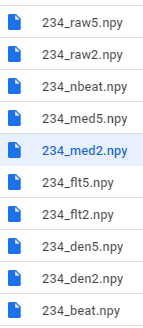

In [0]:
#    C A R E F U L   D O N T     R U N    T H I S 
#---------------------------------------------
# PARAMS
#---------------------------------------------
approach = 1  # select Filtering approach
timestamp_start = datetime.datetime.now()
print(timestamp_start)
print('S T A R T \n')

#_____________________________________________


db_data = all_db.values()
for db in db_data:
    all_rec = db.recs_all
#=========================================================================================
    print ('\n START ON DATABASE: '+ db.name +' \t'+ str(datetime.datetime.now()))
    directory = os.makedirs(os.path.join(global_npydir, db.name+'_npy') , exist_ok = True) 
#=========================================================================================

#=========================================================================================
# STEP 0 : (REQUIRED : Annotation data)
#=========================================================================================
    print ('\n COPY ANNOTATIONS \t'+ str(datetime.datetime.now()))
    # def build_db_ants(self_db, output_postfix):
    build_db_ants(db, g_BEAT_POSTFIX, g_NBEAT_POSTFIX, g_map,all_rec)  


#=========================================================================================
# STEP 1 : (REQUIRED : Signal Data)
#=========================================================================================
    print ('\n EXTRACT RAW SIGNAL \t'+ str(datetime.datetime.now()))
    # def build_db_signal(self_db, output_postfix, lead_indices):  # saves xm.mat[lead2] --> x_raw2.npy
    # use build_db_signal(db, [g_RAW?_POSTFIX],[db.lead?_index]) 
    build_db_signal(db, [g_RAW2_POSTFIX],[db.lead2_index],all_rec)
    build_db_signal(db, [g_RAW5_POSTFIX],[db.lead5_index],all_rec) 

#=========================================================================================
# STEP 2 : (Preprocessing)
#=========================================================================================
    print ('\n FILTER :: RAW -> MED \t'+ str(datetime.datetime.now()))
    # def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix): 
    filter_db_signal(db, [0.2,0.6], g_RAW2_POSTFIX, g_MED2_POSTFIX,all_rec) 
    filter_db_signal(db, [0.2,0.6], g_RAW5_POSTFIX, g_MED5_POSTFIX,all_rec) 

    if approach==0:
        # STEP 2.a : First 'median Filter' the signal then 'denoise' it
        #=========================================================================================
        print ('\n DENOISE :: MED -> FLT \t'+ str(datetime.datetime.now()))
        # def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_MED2_POSTFIX, g_FLT2_POSTFIX,all_rec )
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_MED5_POSTFIX, g_FLT5_POSTFIX,all_rec )
        
    else:
        # STEP 2.b : First 'denoise' the signal then 'median filter' it
        #=========================================================================================
        print ('\n DENOISE :: RAW -> DEN \t'+ str(datetime.datetime.now()))
        # def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_RAW2_POSTFIX, g_DEN2_POSTFIX ,all_rec)
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_RAW5_POSTFIX, g_DEN5_POSTFIX ,all_rec)
        print ('\n FILTER :: DEN -> FLT \t'+ str(datetime.datetime.now()))
        # def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix):  
        filter_db_signal(db, [0.2,0.6], g_DEN2_POSTFIX, g_FLT2_POSTFIX,all_rec) 
        filter_db_signal(db, [0.2,0.6], g_DEN5_POSTFIX, g_FLT5_POSTFIX,all_rec) 
        
    
#=========================================================================================
    print ('\n END ON DATABASE:'+ db.name +' \t'+ str(datetime.datetime.now()))
#=========================================================================================
print('\n E N D ')
timestamp_dur = datetime.datetime.now() - timestamp_start
print(timestamp_dur)
#    C A R E F U L   D O N T     R U N    T H I S 




### [1.3] Delete data_types

In [0]:
#    remove a data type
#---------------------------------------------
# PARAMS
#---------------------------------------------
del_dtypes = ['sig_flt2','sig_flt5', 'mean_flt2', 'medi_flt2', 'mean_flt5', 'medi_flt5']
timestamp_start = datetime.datetime.now()
print(timestamp_start)
print('S T A R T \n')

#_____________________________________________

#tfd = 0
db_data = all_db.values()
for db in db_data:
    all_rec = db.recs_all
#=========================================================================================
    print ('\n START ON DATABASE: '+ db.name +' \t'+ str(datetime.datetime.now()))
#=========================================================================================
    for recs in all_rec:
        rec = db.get_record(recs)
        for ddt in del_dtypes:
            print(rec.del_data(ddt))
            #tfd+=1
#=========================================================================================
    print ('\n END ON DATABASE:'+ db.name +' \t'+ str(datetime.datetime.now()))
#=========================================================================================
print('\n E N D ')
timestamp_dur = datetime.datetime.now() - timestamp_start
print(timestamp_dur)

#    C A R E F U L   D O N T     R U N    T H I S 




## [*2] Re-Sample signal data

In [0]:
# ---CHOOSE PARAMS-------------------------------------------------
# which signal type to choose for data extraction
data_type_postfixL = [g_FLT2_POSTFIX, g_MED2_POSTFIX, g_FLT5_POSTFIX, g_MED5_POSTFIX] # use Baseline fitted signal, can use [ raw, med, den, flt ]
dtype_save_postfixL = dtype_load_postfixL

print('LOAD DT: '+str(data_type_postfixL))
print('SAVE DT: '+str(dtype_save_postfixL))
print('Extract and resample signal data')
print('Basic Sampling rate: '+ str(BASIC_SRATE))
print('Fixed Vector Dim: '+ str(v_dim))
timestamp_start = datetime.datetime.now()
print(timestamp_start)

#------------------------------------------------------------------------
for i in range(0, len(data_type_postfixL)):
    data_type_postfix = data_type_postfixL[i]
    dtype_save_postfix = dtype_save_postfixL[i]

    print('Signal data type: '+ str(data_type_postfix) + ' --> '+ str(dtype_save_postfix))
    all_rpeak = 0
    print('\nDB_RECORD\tNOS_R-PEAKS')
    for db_str in all_db.keys():
        sel_db = all_db[db_str]
        for rec_str in sel_db.recs:
            sel_rec = sel_db.get_record(rec_str)
            rr_binfo = sel_rec.read_binfo()
            sigarr = rr_binfo.load_signal_data(data_type_postfix, v_dim, True, dtype_save_postfix)
            all_rpeak+=rr_binfo.nos_rr_peaks
            print(sel_rec.name+ '\t'+ str(rr_binfo.nos_rr_peaks) )
            #sigarr = rr_binfo.read_signal_data() < ----- next time use this to load saved data
    print('\nTotal Beats = '+ str(all_rpeak))

print('\nEnd of Procedure')
timestamp_dur = datetime.datetime.now() - timestamp_start
print(timestamp_dur)

## [* 3] Find Representative Normals

In [0]:
# CHOOSE PARAMS--------------------------------------------------------------------------------------------
limit_delta_rri = 0.04          # the limit to 'Closeness' of prev and next RR intervals
do_shuf=2                       # set to 0 for no shuffling
min_eps_len = 2 + 2             # the minimum len of N episode ( will skip first and last)
min_epiNorms = 2                # the min number of Normal episodes that must exist for finding rep normal
min_epiNorms_choose = 2         # the min number of Normal episodes that must be taken for generating representation 
variance_limits=[-1, -1]        # selection hard limit on variance among a Normal episode #use -1 to use boundary limits
nosbeats_limits=[-1, -1]        # selection hard limit on number of beats in a Normal episode #use -1 to use boundary limits

dur_start = 0*60              # how many seconds to take # use 30 min to take all
dur_end = 5*60
# dtype_load_postfixL, g_MEDIAN_POSTFIXL, g_MEAN_POSTFIXL = [ 'mean_med2',  'mean_med5']
#----------------------------------------------------------------------------------------------------------



#==============================================================
timestamp_start = datetime.datetime.now()
print(timestamp_start)
print('Start Extacting Representative beats\n')
print('Closeness Limit: '+ str(limit_delta_rri))
print('Min episode N length: '+ str(min_eps_len))
print('Min epiNorm_exsist: '+ str(min_epiNorms))
print('Min_epiNorm_select: '+ str(min_epiNorms_choose))
print('Selection Variance Limits: '+ str(variance_limits))
print('Selection #Beats Limits: '+ str(nosbeats_limits))
print('Limit selection time(sec): '+ str(dur_start)+','+ str(dur_end))
print('Median Postfix: '+ str(g_MEDIAN_POSTFIXL))
print('Mean Postfix: '+ str(g_MEAN_POSTFIXL))
print('Signal DTYPE: '+ str(dtype_load_postfixL))
#==============================================================
for i in range(0,len(dtype_load_postfixL)):
    g_MEDIAN_POSTFIX = g_MEDIAN_POSTFIXL[i]
    g_MEAN_POSTFIX = g_MEAN_POSTFIXL[i]
    dtype_load_postfix=dtype_load_postfixL[i]
    print('\n ...working '+ str(dtype_load_postfix) +' ...\n')
    print('REC\t\tL[-1]\tL[0]\tL[1]\t#epiN\tvar_min\t\t\tvar_max\t\t\tbmin\tbmax\t#selN\tRESULT')
    for db_str in all_db.keys():
        sel_db = all_db[db_str]
        for rec_str in sel_db.recs:

            repstr = ''
            #sel_rec = all_db[db_str].get_random_record()  #all_db[db_str].get_record('I22')
            sel_rec = sel_db.get_record(rec_str)
            sel_rec.del_data(g_MEDIAN_POSTFIX )
            sel_rec.del_data(g_MEAN_POSTFIX )
            repstr+=sel_rec.name+'\t'
            rr_binfo = sel_rec.read_binfo()
            sigarr = rr_binfo.read_signal_data(dtype_load_postfix) #< ----- next time use this to load saved data
    #-------------------------------------------------------------------------------------------------
            len_i = 0
            for i in range(g_LMIN, g_LMAX+1):
                len_i = len(np.where((rr_binfo.rr_int_labels==i) &  (rr_binfo.rr_peaks_sec>=dur_start) & (rr_binfo.rr_peaks_sec<dur_end))[0])
                repstr+= str(len_i) +'\t'
    #-------------------------------------------------------------------------------------------------
            nac_query = ((rr_binfo.rr_int_labels==0) &
                        (np.abs(rr_binfo.rri_delta)<=limit_delta_rri) &
                        (rr_binfo.rr_peaks_sec>=dur_start) & (rr_binfo.rr_peaks_sec<dur_end) )
    #-------------------------------------------------------------------------------------------------
            nac_where = np.where(nac_query)[0]
            # filter episodes by min_len
            epiNorm = get_episodes(nac_where,min_eps_len)
            nos_epinorm = len(epiNorm)
            #print('All NAC Episodes of min length ['+ str(min_eps_len) +'] = '+ str(nos_epinorm))
            repstr+= str(nos_epinorm) +'\t'
    #-------------------------------------------------------------------------------------------------------
        # PART 2 : Representative episodal BEATS
            #print('[2] FIND REPRESENTATIVE NORMAL')
    #-------------------------------------------------------------------------------------------------
            if nos_epinorm<min_epiNorms:
                #print( 'WARNING:: NOT ENOUGH NORMAL EPISODES ..... skip this record')
                repstr+= 'NOT ENOUGH NORMAL EPISODES'
                print(repstr)
                continue
            medNorm = np.zeros((0,v_dim), dtype='float')
            menNorm = np.zeros((0,v_dim), dtype='float')
            varNorm = np.zeros((0,v_dim), dtype='float')
            for ie in range(0,nos_epinorm):
                # select normal beats form this episode
                sigX = sigarr[ epiNorm[ie][0] + 1 : epiNorm[ie][1] - 1 ] # skip first and last
                # calculate mean, median, variance for each episode
                men_beatX, med_beatX, var_beatX = gen_MMV(sigX)
                menNorm = np.vstack((menNorm, men_beatX))
                medNorm = np.vstack((medNorm, med_beatX))
                varNorm = np.vstack((varNorm, var_beatX))

            escat = np.zeros((nos_epinorm, 2))
            #print('#epi\t#beat\tvariance')
            for i in range(0, nos_epinorm):
                escat[i][0] = np.average(varNorm[i])        # variation
                escat[i][1] = (epiNorm[i][1]-epiNorm[i][0]) -2        # nos beats
                #print(str(i)+'\t'+str(int(escat[i][1]))+'\t'+str(round(escat[i][0],6)))
            epiN_max_variance = np.max(escat[:,0])
            epiN_min_variance = np.min(escat[:,0])
            epiN_max_nbeats = np.max(escat[:,1])
            epiN_min_nbeats = np.min(escat[:,1])

            #print('Variance Range : '+ str(epiN_min_variance)+ ':'+str(epiN_max_variance))
            #print('#Beats Range : '+ str(epiN_min_nbeats)+ ':'+str(epiN_max_nbeats))
            repstr+= str(epiN_min_variance) + '\t'
            repstr+= str(epiN_max_variance) +'\t'
            repstr+= str(epiN_min_nbeats) + '\t'
            repstr+= str(epiN_max_nbeats) + '\t'

    #-------------------------------------------------------------------------------------------------------
        # PART 3 [*] : SELECT NAC episodes to build REP BEAT
            #print('[3] SELECT NAC episodes to build REPRESENTATIVE NORMAL')
    #-------------------------------------------------------------------------------------------------
            #sel_var_limit =  [epiN_min_variance, epiN_max_variance]
            #sel_nbeat_limit = [epiN_min_nbeats,epiN_max_nbeats ]
            sel_var_limit =  [0, 0]
            sel_nbeat_limit = [0, 0]
            if variance_limits[0]<0:
                sel_var_limit[0] = epiN_min_variance
            else:
                sel_var_limit[0] = variance_limits[0]
            if variance_limits[1]<0:
                sel_var_limit[1] = epiN_max_variance
            else:
                sel_var_limit[1] = variance_limits[1]
            if nosbeats_limits[0]<0:
                sel_nbeat_limit[0] = epiN_min_nbeats
            else:
                sel_nbeat_limit[0] = nosbeats_limits[0]         
            if nosbeats_limits[1]<0:
                sel_nbeat_limit[1] = epiN_max_nbeats
            else:
                sel_nbeat_limit[1] = nosbeats_limits[1]         
            
            # select episodes within defined limits
            sig_epi_rep = medNorm [(escat[:,0]>=sel_var_limit[0]) & 
                                (escat[:,0]<=sel_var_limit[1]) &
                                (escat[:,1]>=sel_nbeat_limit[0]) & 
                                (escat[:,1]<=sel_nbeat_limit[1])]

            #print('Episodes taken = '+ str(len(sig_epi_rep)))
            repstr+= str(len(sig_epi_rep)) + '\t'
            if len(sig_epi_rep)>=min_epiNorms_choose:
                mean_of_med, med_of_med, _ =  gen_MMV(sig_epi_rep)
                #print('...success in finding representative normal')
                repstr+= 'SUCCESS'
                print(repstr)
                sel_rec.save_data(g_MEDIAN_POSTFIX,med_of_med )
                sel_rec.save_data(g_MEAN_POSTFIX,mean_of_med )
            else:
                #print( 'WARNING:: NOT ENOUGH NORMAL EPISODES COULD BE CHOOSEN..... skip this record')
                repstr+= 'NOT ENOUGH NORMAL EPISODES WERE CHOOSEN'
                print(repstr)
                #mega_rep.append([ sel_rec.name, med_of_med, mean_of_med  ])



print('\n============================================================================')
print('\nEnd Extacting Signal Data and Representative beats')
timestamp_dur = datetime.datetime.now() - timestamp_start
print(timestamp_dur)

## [*4] plot representatives

In [0]:
#recc = all_db['mitdb'].get_record('108')
ff=0
db_data = all_db.values()
for db in db_data:
    all_rec = db.recs_all
    for recs in all_rec:
        recc = db.get_record(recs)
        for g in range(0, len(g_MEDIAN_POSTFIXL)):
            plt.figure(ff)
            ff+=1
            try:
                plt.plot(recc.read_data(g_MEAN_POSTFIXL[g]), color='red', label='mean', linewidth = 0.5)
                plt.plot(recc.read_data(g_MEDIAN_POSTFIXL[g]), color='black', label='median', linewidth = 0.7)
                plt.title(recc.name+ ':' +
                          str(g_MEAN_POSTFIXL[g]))
                plt.legend()
                plt.show()
            except:
                #print('No Representative for '+ str(recc.name))
                print('\n')


# TRAINING

## DB_DICT for Training

In [0]:

train_db = {}
#------------------------------------------------------------------------
mitdb_ex = [
            '102', '104', '107', '217',     # contains paced beats
            '212', '231',                   # contains both Normal and BBB type beats
            '207',                          # contains both RBBB and LBBB type beats
            '108',                          # bad record data on lead2
            '228' ,                          # not enough normal episodes of min len 10
             '232','221',                     # not enough normals
            '107','123','201', '203', '219',  '101','200','210',                     # no rep beat

            ]
train_db['mitdb'] = ecg_db('mitdb', 360, 0, 1, mitdb_ex)
#------------------------------------------------------------------------
svdb_ex = [
           '852',                            # missing lead2 signal
           '860', '822', '858','854','892',
          ]
train_db['svdb'] = ecg_db('svdb',  128, 0, 1,svdb_ex)
#------------------------------------------------------------------------
incartdb_ex = [
               'I03',                        # bad rep beats
               'I43',                       # not enough normals
               'I53',                       # not enough normals
               'I19', 'I51', 'I42','I59','I41','I75'                       # not enough normals
                ]
#train_db['incartdb'] = ecg_db('incartdb', 257, 1, 10,incartdb_ex)
#------------------------------------------------------------------------
#print(train_db.values())
print('')
print(train_db.keys())


Initailze new ecg database ... 
DB NAME :: mitdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/mitdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
S_RATE :: 360
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [30] {'114', '233', '208', '118', '119', '215', '213', '202', '124', '205', '230', '115', '112', '105', '234', '223', '109', '214', '122', '106', '103', '111', '116', '220', '117', '113', '121', '209', '100', '222'}

Initailze new ecg database ... 
DB NAME :: svdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/svdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
S_RATE :: 128
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [72] {'823', '885', '811', '893', '824', '889', '844', '851', '848', '884', '803', '855', '821', '812', '826', '870', '890', '867', '802', '850', '808', '878', '840', '800', '881', '856', '894', '865', '859', '864', '806', '804', '827', '866', '886', 

## PREPARE TRAINING DATA

In [0]:
# CHOOSE PARAMS -----------------------------------------------------------------------------
# dtype_load_postfixL, g_MEDIAN_POSTFIXL, g_MEAN_POSTFIXL = [ 'mean_med2',  'mean_med5']
ds_nameL = ['e2_train_med2', 'e2_train_med5']           # to save training dataset as 

dur_start = 0*60                # sec, from
dur_end = 30*60                 # sec, to
nos_min_cutoff = 200              # Min beats of either type, after dividing into test & train sets
nos_max_cutoff = 500              # Min beats of either type, after dividing into test & train sets
min_Abeats, min_Nbeats = 200, 200 # Min Abeats, Nbeeats to exist in the record for it be choosen
use_median_as_rep = True        # if True like it says, otherwise use mean as the representative beat
use_nac_for_training = False    # if True, uses only NAC episodes to extract N beats for training
train_ratio = 1               #<-- for training : testing
do_shuf = 2
#================================================================================================


timestamp_start = datetime.datetime.now()
print(timestamp_start)
print('Start Experiment\n')
print('NAC Only Training\t'+ str(use_nac_for_training))
print('Training : Testing Ratio for Dataset  \t'+ str(train_ratio))
print('Use Median as Representaive Normal \t'+ str(use_median_as_rep))
print('Limit selection time(sec): '+ str(dur_start)+','+  str(dur_end))
print('N,A selection #beats: '+ str(min_Nbeats)+','+  str(min_Abeats))
#==============================================================
for i in range(0, len(ds_nameL)):
    print('\n ...working '+str(ds_nameL[i])+'...\n')
    g_MEDIAN_POSTFIX = g_MEDIAN_POSTFIXL[i]
    g_MEAN_POSTFIX = g_MEAN_POSTFIXL[i]
    dtype_load_postfix = dtype_load_postfixL[i]
    ds_name = ds_nameL[i]
    #>>>>>>>>>>>>>>>>>>> SPLIT LOOP HERE
    all_train = np.zeros((0, v_dim*2 + 2), dtype='float')
    total_lab_taken = [0,0]
    rec_taken = 0
    for db_str in train_db.keys():
        
    #db_str = random.choice(list(train_db.keys())) # 'svdb'
        sel_db = train_db[db_str]
        for rec_str in sel_db.recs:
            #sel_rec = train_db[db_str].get_random_record()  #train_db[db_str].get_record('I22')
            sel_rec = sel_db.get_record(rec_str)
    #-------------------------------------------------------------------------------------------------   
            #print('\n============================================================================')
            #print (sel_rec.name)
            jp = sel_rec.name+'\t'
            srate = sel_rec.db.srate
            mgain = sel_rec.gain
    #-------------------------------------------------------------------------------------------------
        # PART 0 : Load data
    #-------------------------------------------------------------------------------------------------
            # step 1 : get ecg_record object
            #print ('Preparing information...')
            rr_binfo = sel_rec.read_binfo()

            # step 2 : load its signal
            #print ('Loading signal...')
            #sigarr = rr_binfo.load_signal_data(g_data_postfix, v_dim, True)#<------- was done in perv loop
            sigarr = rr_binfo.read_signal_data(dtype_load_postfix)

            #print('...done!')
    #-------------------------------------------------------------------------------------------------
        # PART 1 : FIND NAC
    #-------------------------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------------------------
        # PART 4 [*] : PREPARE DATA
    #-------------------------------------------------------------------------------------------------------
            # 1 choose the median representative beat
            if use_median_as_rep:
                data_med = g_MEDIAN_POSTFIX 
            else:
                data_med = g_MEAN_POSTFIX
            
    # ===== SET 1 ==============================================================================
            # REQUIRE: ratio train:test
            # 2 SELECT NORMAL BEATS
            if use_nac_for_training:
                nac_query = ((rr_binfo.rr_int_labels==0) &
                        (np.abs(rr_binfo.rri_delta)<=limit_delta_rri) &
                        (rr_binfo.rr_peaks_sec>=dur_start) & (rr_binfo.rr_peaks_sec<dur_end) )
                N_where = np.where(nac_query)[0]  # <<========for training use only NAC beats
            else:
                nac_query = ((rr_binfo.rr_int_labels==0) &
                        #(np.abs(rr_binfo.rri_delta)<=limit_delta_rri) &
                        (rr_binfo.rr_peaks_sec>=dur_start) & (rr_binfo.rr_peaks_sec<dur_end) )
                N_where = np.where(nac_query)[0] # <<=====  use all N beats

            a_query = ((rr_binfo.rr_int_labels>0) & 
                    (rr_binfo.rr_peaks_sec>=dur_start) & (rr_binfo.rr_peaks_sec<dur_end) )
            A_where = np.where(a_query)[0]
            #if not take_all:
            jp+=  str(len(N_where))+'\t'+str(len(A_where))+'\t'
            if len(A_where) < min_Abeats or len(N_where) < min_Nbeats:
                #print( )
                jp+='WARNING:: Not enough beats of each type were FOUND..... skip this record'
                print(jp)
                continue
            data_Q = get_data_from_query([N_where, A_where], rr_binfo, data_med, 6)
            if data_Q == None:
                #print( 'WARNING:: No REPRESENTATIVE FOUND..... skip this record')
                continue

            data_N, data_A = data_Q[0], data_Q[1]
            
            ##================ DIVIDE DATA INTO TRAIN:TEST
            nos_N, nos_A = len(data_N), len(data_A)
            #print('Nos [N,A] = ['+ str(nos_N)+','+str(nos_A)+']')
            jp+=  str(nos_N)+'\t'+str(nos_A)+'\t'

            take_NA = int(train_ratio* min(nos_N, nos_A))
            #print('Nos [N,A] = ['+ str(nos_N)+','+str(nos_A)+']\tTake = '+str(take_NA))
            if take_NA < nos_min_cutoff :
                # print( 'WARNING:: NOT ENOUGH BEATS OF EITHER LABEL TYPE  ..... skip this record')
                jp += 'WARNING:: NOT ENOUGH BEATS OF EITHER LABEL TYPE  ..... skip this record'
                print(jp)
                continue
            
            take_NA = max(take_NA,nos_max_cutoff )
            data_train = np.vstack( (  data_N[0:take_NA], data_A[0:take_NA]  ) )   #=========# TRAINING DATA
            total_lab_taken[0] += take_NA
            total_lab_taken[1] += take_NA

            if len(data_train)==0:
                #print( 'WARNING:: NOT ENOUGH DATA ..... skip this record')
                jp+= 'WARNING:: NOT ENOUGH DATA ..... skip this record'
                print(jp)
                continue

            for i in range(0,do_shuf):
                np.random.shuffle(data_train)        # shuffle training data
                #np.random.shuffle(data_test)          # no need to shuffle testing data
            #================================================= PRINT RESULTS
            #print('Vector Dim: ' + str(v_dim))
            #print('Training Data Ratio ' + str(train_ratio))
            #print('Training = '+ str(data_train.shape))
            rec_taken+=1
            all_train = np.vstack((all_train,data_train))
            print(jp)
    # =================================================================================================================

    print('Total beats = ' + str(len(all_train))+ ' from '+ str(rec_taken)+ ' records')
    print('[N, A] = '+str(total_lab_taken))
    svpth = os.path.join(global_datadir, ds_name +'.npy' )
    np.save( svpth , all_train)
    print('saved at ' + str(svpth))

print('\nEnd Procedure\n')
timestamp_dur = datetime.datetime.now() - timestamp_start
print(timestamp_dur)
#print('TOTAL REP BEATS in database = '+ str(len(mega_rep)))

2020-03-21 16:25:00.836205
Start Experiment

NAC Only Training	False
Training : Testing Ratio for Dataset  	1
Use Median as Representaive Normal 	True
Limit selection time(sec): 0,1800
N,A selection #beats: 200,200

 ...working e2_train_med2...

mitdb_114	1812	59	WARNING:: Not enough beats of each type were FOUND..... skip this record
mitdb_233	2222	846	2222	846	
mitdb_208	1581	1364	1581	1364	
mitdb_118	2160	110	WARNING:: Not enough beats of each type were FOUND..... skip this record
mitdb_119	1536	444	1536	444	
mitdb_215	3184	168	WARNING:: Not enough beats of each type were FOUND..... skip this record
mitdb_213	2631	609	2631	609	
mitdb_202	2052	75	WARNING:: Not enough beats of each type were FOUND..... skip this record
mitdb_124	1524	88	WARNING:: Not enough beats of each type were FOUND..... skip this record
mitdb_205	2562	85	WARNING:: Not enough beats of each type were FOUND..... skip this record
mitdb_230	2246	1	WARNING:: Not enough beats of each type were FOUND..... skip this recor

## PREFORM TRAINING

In [0]:
print('Available Datasets::')
ds = os.listdir(global_datadir)
for lf in ds:
    print(lf)
print('\nAvailable Models::')
ds = os.listdir(global_modeldir)
for lf in ds:
    print(lf)

Available Datasets::
e2_train_med2.npy
e2_train_med5.npy

Available Models::
e1_train_flt2.h5
e1_train_med2.h5
e1_train_flt5.h5
e1_train_med5.h5


2020-03-21 16:44:04.751162
Start Training


 ...working e2_train_med2 ...

Loaded beats: (40800,)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_basic (InputLayer)        [(None, 384, 1)]     0                                            
__________________________________________________________________________________________________
input_compar (InputLayer)       [(None, 384, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 382, 20)      80          input_basic[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv

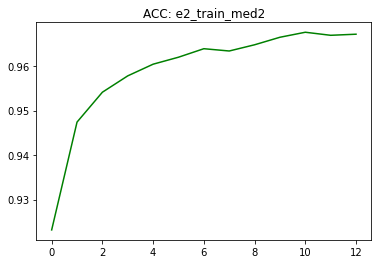

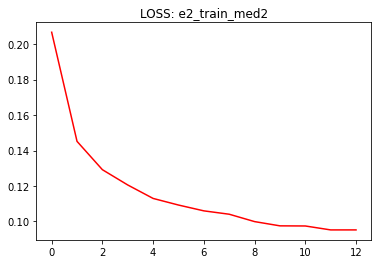

saved model at /content/drive/My Drive/Masters/workdir/ecg_data/db_model/e2_model_med2.h5

 ...working e2_train_med5 ...

Loaded beats: (40800,)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_basic (InputLayer)        [(None, 384, 1)]     0                                            
__________________________________________________________________________________________________
input_compar (InputLayer)       [(None, 384, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 382, 20)      80          input_basic[0][0]                
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 382, 20

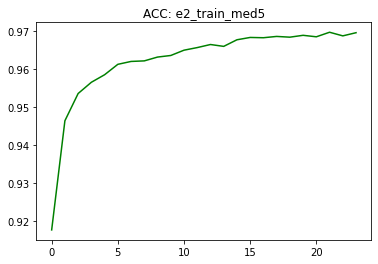

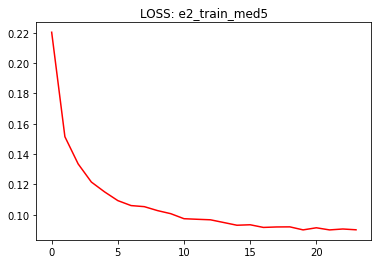

saved model at /content/drive/My Drive/Masters/workdir/ecg_data/db_model/e2_model_med5.h5
End Procedure

0:12:11.558511


In [0]:
# CHOOSE PARAMS
ds_nameL = [ 'e2_train_med2', 'e2_train_med5']                       # dataset to train upon (load this)
ds_modelL = ['e2_model_med2', 'e2_model_med5']                          # save model as
ff=0

#==============================================================
timestamp_start = datetime.datetime.now()
print(timestamp_start)
print('Start Training\n')
for i in range(0,len(ds_nameL)):
    #==============================================================
    ds_name = ds_nameL[i]
    print('\n ...working '+ str(ds_name)+' ...\n')
    #>>>>>>>>>>>>>>>>>>> SPLIT LOOP HERE

    all_train = np.load( os.path.join(global_datadir, ds_name + '.npy' )) 
    Dm, Dx, Dy, _ = get_shaped_data(all_train, v_dim)

    #-------------------------------------------------------------------------------------------------------
    data_x = [Dm, Dx]
    data_y = Dy

    print('Loaded beats: ' + str(data_y.shape))
    #-------------------------------------------------------------------------------------------------------


    model = get_model(True, (v_dim,1), (v_dim,1))
    history = model.fit(
                        data_x, data_y,
                        #batch_size=1000,
                        epochs=300,
                        callbacks=cb_listr,
                        #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                        shuffle=True,
                        verbose=1)

    plt.figure(ff)
    ff+=1
    plt.title('ACC: '+ds_name)
    plt.plot(history.history['acc'],color='green')
    plt.show()

    plt.figure(ff)
    ff+=1
    plt.title('LOSS: '+ds_name)
    plt.plot(history.history['loss'],color='red')
    plt.show()

    #save this model
    save_model_name = ds_modelL[i] +'.h5'        # save model weights to this file
    svmpth = os.path.join(global_modeldir, save_model_name)
    model.save_weights(svmpth)
    #print('Saved Model : '+save_model_name )
    print('saved model at '+ str(svmpth))
    #-------------------------------------------------------------------------------------------------------
    # 
print('End Procedure\n')
timestamp_dur = datetime.datetime.now() - timestamp_start
print(timestamp_dur)
#print('TOTAL REP BEATS in database = '+ str(len(mega_rep)))

# TESTING

## DB DICT for Testing

In [0]:

test_db = {}
#------------------------------------------------------------------------
mitdb_ex = [
            '102', '104', '107', '217',     # contains paced beats
            '212', '231',                   # contains both Normal and BBB type beats
            '207',                          # contains both RBBB and LBBB type beats
            #'108',                          # bad record data on lead2
            #'228'                           # not enough normal episodes of min len 10
             '232','221'                     # not enough normals
            ]
#test_db['mitdb'] = ecg_db('mitdb', 360, 0, 1, mitdb_ex)
#------------------------------------------------------------------------
svdb_ex = [
           '852'                            # missing lead2 signal
          ]
#test_db['svdb'] = ecg_db('svdb',  128, 0, 1,svdb_ex)
#------------------------------------------------------------------------
incartdb_ex = [
               'I03',                        # bad rep beats
               'I43',                       # not enough normals
               'I53',                       # not enough normals
               'I19'                        # not enough normals
                ]
test_db['incartdb'] = ecg_db('incartdb', 257, 1, 10,incartdb_ex)
#------------------------------------------------------------------------
#print(test_db.values())
print('')
print(test_db.keys())


Initailze new ecg database ... 
DB NAME :: incartdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/incartdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/incartdb_npy
S_RATE :: 257
LEAD2 INDEX  :: 1
LEAD5 INDEX  :: 10
RECORD SET :: [71] {'I58', 'I54', 'I20', 'I73', 'I17', 'I26', 'I64', 'I71', 'I12', 'I66', 'I21', 'I18', 'I08', 'I59', 'I50', 'I02', 'I63', 'I28', 'I11', 'I06', 'I07', 'I13', 'I41', 'I23', 'I05', 'I34', 'I75', 'I33', 'I39', 'I31', 'I45', 'I24', 'I32', 'I67', 'I48', 'I70', 'I27', 'I62', 'I09', 'I35', 'I74', 'I30', 'I57', 'I51', 'I42', 'I16', 'I29', 'I36', 'I38', 'I68', 'I15', 'I04', 'I10', 'I46', 'I55', 'I01', 'I44', 'I47', 'I61', 'I40', 'I60', 'I37', 'I49', 'I14', 'I22', 'I72', 'I56', 'I65', 'I52', 'I25', 'I69'}

dict_keys(['incartdb'])


## PREPARE TESTING DATA

In [0]:
# CHOOSE PARAMS------------------------------------
# dtype_load_postfixL, g_MEDIAN_POSTFIXL, g_MEAN_POSTFIXL = [ 'mean_med2',  'mean_med5']
ds_nameL = ['e2_test_med2', 'e2_test_med5']           # to save testing data as  

dur_start = 0*60                # sec from
dur_end = 30*60                 # sec, to
min_Abeats,min_Nbeats = 10, 10         
use_median_as_rep = True        # otherwise use mean as the representative beat
use_nac_for_testing = False    # if True, uses only NAC episodes to extract N beats for testing
do_shuf = 0
#==============================================================


timestamp_start = datetime.datetime.now()
print(timestamp_start)
print('Start Experiment\n')
print('NAC Only \t'+ str(use_nac_for_testing))
print('Use Median as Representaive Normal \t'+ str(use_median_as_rep))
print('Limit selection time(sec): '+ str(dur_start)+','+  str(dur_end))
print('N,A selection #beats: '+ str(min_Nbeats)+','+  str(min_Abeats))
#==============================================================
for i in range(0,len(ds_nameL)):
    g_MEDIAN_POSTFIX = g_MEDIAN_POSTFIXL[i]
    g_MEAN_POSTFIX = g_MEAN_POSTFIXL[i]
    dtype_load_postfix = dtype_load_postfixL[i]
    ds_name = ds_nameL[i]

    print('\n ...working'+str(ds_name)+' ...\n')
    #>>>>>>>>>>>>>>>>>>> SPLIT LOOP HERE
    all_test = np.zeros((0, v_dim*2 + 2), dtype='float')
    total_lab_taken = [0,0]
    rec_taken = 0
    for db_str in test_db.keys():
        
    #db_str = random.choice(list(test_db.keys())) # 'svdb'
        sel_db = test_db[db_str]
        for rec_str in sel_db.recs:
            #sel_rec = test_db[db_str].get_random_record()  #test_db[db_str].get_record('I22')
            sel_rec = sel_db.get_record(rec_str)
    #-------------------------------------------------------------------------------------------------   
            #print('\n============================================================================')
            #print (sel_rec.name)
            jp = sel_rec.name+'\t'
            srate = sel_rec.db.srate
            mgain = sel_rec.gain
    #-------------------------------------------------------------------------------------------------
        # PART 0 : Load data
    #-------------------------------------------------------------------------------------------------
            # step 1 : get ecg_record object
            #print ('Preparing information...')
            rr_binfo = sel_rec.read_binfo()

            # step 2 : load its signal
            #print ('Loading signal...')
            #sigarr = rr_binfo.load_signal_data(g_data_postfix, v_dim, True)#<------- was done in perv loop
            sigarr = rr_binfo.read_signal_data(dtype_load_postfix)

            #print('...done!')
    #-------------------------------------------------------------------------------------------------
        # PART 1 : FIND NAC
    #-------------------------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------------------------------
        # PART 4 [*] : PREPARE DATA
    #-------------------------------------------------------------------------------------------------------
            # 1 choose the median representative beat
            if use_median_as_rep:
                data_med = g_MEDIAN_POSTFIX 
            else:
                data_med = g_MEAN_POSTFIX
            
    # ===== SET 1 ==============================================================================
            # REQUIRE: ratio train:test
            # 2 SELECT NORMAL BEATS
            if use_nac_for_testing:
                nac_query = ((rr_binfo.rr_int_labels==0) &
                        (np.abs(rr_binfo.rri_delta)<=limit_delta_rri) &
                        (rr_binfo.rr_peaks_sec>=dur_start) & (rr_binfo.rr_peaks_sec<dur_end) )
                N_where = np.where(nac_query)[0]  # <<========for training use only NAC beats
            else:
                nac_query = ((rr_binfo.rr_int_labels==0) &
                        #(np.abs(rr_binfo.rri_delta)<=limit_delta_rri) &
                        (rr_binfo.rr_peaks_sec>=dur_start) & (rr_binfo.rr_peaks_sec<dur_end) )
                N_where = np.where(nac_query)[0] # <<=====  use all N beats

            a_query = ((rr_binfo.rr_int_labels>0) & 
                    (rr_binfo.rr_peaks_sec>=dur_start) & (rr_binfo.rr_peaks_sec<dur_end) )
            A_where = np.where(a_query)[0]
            #if not take_all:
            jp+=  str(len(N_where))+'\t'+str(len(A_where))+'\t'
            if len(A_where) < min_Abeats or len(N_where) < min_Nbeats:
                #print( )
                jp+='WARNING:: Not enough beats of each type were FOUND..... skip this record'
                print(jp)
                continue
            data_Q = get_data_from_query([N_where, A_where], rr_binfo, data_med, 0)
            if data_Q == None:
                #print( 'WARNING:: No REPRESENTATIVE FOUND..... skip this record')
                continue

            data_N, data_A = data_Q[0], data_Q[1]
            
            ##================ DIVIDE DATA INTO TRAIN:TEST
            nos_N, nos_A = len(data_N), len(data_A)
            #print('Nos [N,A] = ['+ str(nos_N)+','+str(nos_A)+']')
            jp+=  str(nos_N)+'\t'+str(nos_A)+'\t'

            data_test = np.vstack( (  data_N, data_A  ) )
            total_lab_taken[0] += nos_N
            total_lab_taken[1] += nos_A



            if len(data_test)==0:
                #print( 'WARNING:: NOT ENOUGH DATA ..... skip this record')
                jp+= 'WARNING:: NOT ENOUGH DATA ..... skip this record'
                print(jp)
                continue

            #for i in range(0,do_shuf):
            #    np.random.shuffle(data_test)        # shuffle training data
                #np.random.shuffle(data_test)          # no need to shuffle testing data
            #================================================= PRINT RESULTS
            #print('Vector Dim: ' + str(v_dim))
            #print('Training Data Ratio ' + str(train_ratio))
            #print('Training = '+ str(data_train.shape))
            rec_taken+=1
            all_test = np.vstack((all_test,data_test))
            print(jp)
    # =================================================================================================================
    #-------------------------------------------------------------------------------------------------------
        #print('=========================================================================== EoR\n')
    #-------------------------------------------------------------------------------------------------------
    #print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EoE\n')
    print('Total beats = ' + str(len(all_test))+ ' from '+ str(rec_taken)+ ' records')
    print('[N, A] = '+str(total_lab_taken))
    svpth = os.path.join(global_datadir, ds_name +'.npy' )
    np.save( svpth , all_test)
    print('saved at ' + str(svpth))
print('End Procedure\n')
timestamp_dur = datetime.datetime.now() - timestamp_start
print(timestamp_dur)
#print('TOTAL REP BEATS in database = '+ str(len(mega_rep)))

2020-03-21 16:56:55.791030
Start Experiment

NAC Only 	False
Use Median as Representaive Normal 	True
Limit selection time(sec): 0,1800
N,A selection #beats: 10,10

 ...workinge2_test_med2 ...

incartdb_I58	2311	12	2311	12	
incartdb_I54	2338	23	2338	23	
incartdb_I20	2360	290	2360	290	
incartdb_I73	1888	102	1888	102	
incartdb_I17	1643	27	1643	27	
incartdb_I26	1496	11	1496	11	
incartdb_I64	1885	26	1885	26	
incartdb_I71	1633	35	1633	35	
incartdb_I12	2798	9	WARNING:: Not enough beats of each type were FOUND..... skip this record
incartdb_I66	2137	201	2137	201	
incartdb_I21	2070	112	2070	112	
incartdb_I18	2660	422	2660	422	
incartdb_I08	1776	353	1776	353	
incartdb_I50	2992	4	WARNING:: Not enough beats of each type were FOUND..... skip this record
incartdb_I02	2443	229	2443	229	
incartdb_I63	1845	147	1845	147	
incartdb_I28	1711	4	WARNING:: Not enough beats of each type were FOUND..... skip this record
incartdb_I11	2076	28	2076	28	
incartdb_I06	2434	57	2434	57	
incartdb_I07	2638	66	2638	66	
i

## PERFORM TESTING

In [11]:
print('Available Datasets::')
ds = os.listdir(global_datadir)
for lf in ds:
    print(lf)
print('\nAvailable Models::')
ds = os.listdir(global_modeldir)
for lf in ds:
    print(lf)

Available Datasets::

Available Models::


In [10]:
# Choose Params----------------------------------
# dtype_load_postfixL, g_MEDIAN_POSTFIXL, g_MEAN_POSTFIXL = [ 'mean_med2',  'mean_med5']
ds_nameL = ['e2_test_med2', 'e2_test_med5']           # to load test set    
ds_modelL = ['e2_model_med2', 'e2_model_med5']        # to load model weights
#-------------------------------------------------------------------------------------------------------

for iI in range(0, len(ds_nameL)):
    ds_name = ds_nameL[iI]
    print('\n... working '+str(ds_name)+ '...\n')
#==============================================================================
    all_test = np.load( os.path.join(global_datadir, ds_name + '.npy' )) 
    Dm, Dx, Dy, Dp = get_shaped_data(all_test,v_dim)

    #-------------------------------------------------------------------------------------------------------
    data_x = [Dm, Dx]
    data_y = Dy
    print('Loaded beats: ' + str(data_y.shape))
    #-------------------------------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------
    #get the model - skip this to use the on same model as on training
    model = get_model(False, (v_dim,1), (v_dim,1))
    load_model_name = ds_modelL[iI] + '.h5'     # model used for testing
    model.load_weights(os.path.join(global_modeldir, load_model_name))
    #-------------------------------------------------------------------------------------------------------
    #model.evaluate( x=data_x, y=data_y )
    #-------------------------------------------------------------------------------------------------------
    # manual prediction
    print('Manual Prediction on REC: ' + ds_name)

    #evla = model.evaluate( data_x, data_y ) data_med med_rep
    #print(evla)
    #print ('Predict on dataset '+ sel_ds + ' using model ' + global_model_name) 
    predx = model.predict( data_x ) # array of  samples x classes(4) - each row is a prediction of sample
    cmx_global = np.zeros((2,2),dtype='int32')
    cmx2_global = predx.argmax(axis=1)
    for i in range(0,len(cmx2_global)):
        alabel = int(data_y[i])
        plabel = cmx2_global[i]
        cmx_global[alabel,plabel]+=1
    print('\tConfusion Matrix')
    print(print_conf_matrix( cmx_global,'', g_LABELS)) #logit('\t'+str(cmx))
    print_performance( get_performance(cmx_global) ,g_LABELS ) 
    #-------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------
# 
#-------------------------------------------------------------------------------------------------------




... working e2_test_med2...

Loaded beats: (137613,)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Manual Prediction on REC: e2_test_med2
	Confusion Matrix
A\P	N	A
N	115567	6099
A	1446	14501

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.95	0.99	0.95	0.91
A	0.95	0.7	0.91	0.95

... working e2_test_med5...

Loaded beats: (137613,)
Manual Prediction on REC: e2_test_med5
	Confusion Matrix
A\P	N	A
N	117773	3893
A	1057	14890

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.96	0.99	0.97	0.93
A	0.96	0.79	0.93	0.97


# View Results

(1057,)


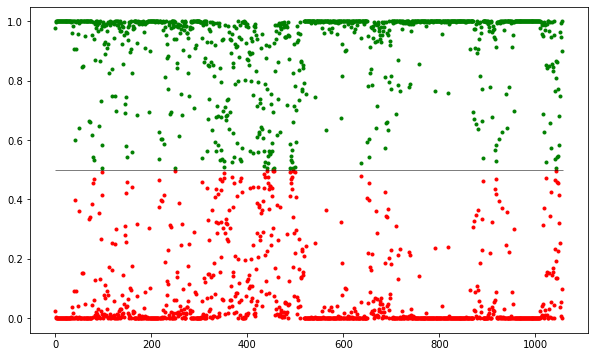

In [0]:
#vi = 14 # random.randint(0, len(Dp)-1)
via = np.where( (Dy>cmx2_global))[0]  
# > for missed Abnormals wrongly prediced as Normals
# < for false positive Normals, Normals wrongly prediced as abNormals
print(via.shape)
vii=0
predconfs = predx[via]
plt.figure(0, figsize=(10,6))
#plt.plot(predconfs[:,0])
plt.scatter(np.arange(0,len(predconfs),1),predconfs[:,0], marker= '.',color='green' )
plt.scatter(np.arange(0,len(predconfs),1),predconfs[:,1], marker= '.',color='red' )
plt.hlines(0.5,0,len(predconfs),color='black', linewidth=0.5)

#7044


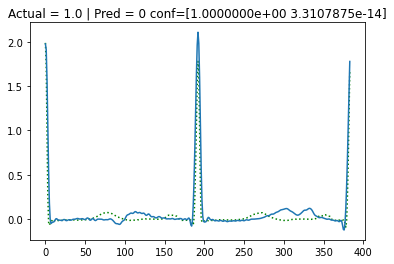

In [0]:


vi = via[vii]
print('#'+ str(vi))



plt.plot(Dm[vi], color='green', label = 'rep', linestyle = 'dotted')
plt.plot(Dx[vi], label = 'beat')
plt.title('Actual = ' + str(Dy[vi])+ ' | Pred = '+str(cmx2_global[vi])+ ' conf='+str(predx[vi]))
#plt.plot(Dp[vi])

#view_beat(0, sel_rec, Dp[vi], g_MED2_POSTFIX )
vii+=1

Conclusion:

> med5 works better in this case

> small diffenerences are not really captured - use larger filter size